In [6]:
pip install paho-mqtt

Note: you may need to restart the kernel to use updated packages.


In [14]:
import paho.mqtt.subscribe as subscribe
import csv
import json
import os
import pandas as pd

# Raw MQTT topics
topics = ['time', 'temp', 'air_quality', 'humidity']

# Friendly column labels
labels = ['time', 'temp', 'air quality', 'humidity']

n = 6  # number of cycles

csv_file = "mqtt_data_test.csv"
json_file = "mqtt_data_test.json"

# -----------------------
# SET UP CSV
# -----------------------
write_csv_header = not os.path.exists(csv_file)
csv_fh = open(csv_file, "a", newline="")
csv_writer = csv.writer(csv_fh)

if write_csv_header:
    csv_writer.writerow(["cycles"] + labels)

# -----------------------
# SET UP JSON
# -----------------------
json_fh = open(json_file, "a")

# -----------------------
# STORAGE FOR FINAL TABLE
# -----------------------
table_rows = []   # list of lists: [cycle, time, temp, aq, humidity]

# -----------------------
# MAIN LOOP
# -----------------------
for i in range(n):
    # Read MQTT messages
    m = subscribe.simple(
        topics,
        hostname="test.mosquitto.org",
        retained=False,
        msg_count=len(topics)
    )

    values = [msg.payload.decode("utf-8") for msg in m]

      # Store for DataFrame
    row_dict = {"cycle": i}
    for label, value in zip(labels, values):
        row_dict[label] = value
    table_rows.append(row_dict)

    # Write CSV
    csv_writer.writerow([i] + values)

    # Write JSON (one JSON object per line)
    json_fh.write(json.dumps(row_dict) + "\n")

# Close files
csv_fh.close()
json_fh.close()


# BUILD DATAFRAME

df = pd.DataFrame(table_rows)


# PRINT DATAFRAME

df


,cycle,time,temp,air quality,humidity
0,0,49,21.37,25,0.00
1,1,79,21.64,25,0.00
2,2,109,21.85,25,0.00
3,3,139,22.01,25,0.00
4,4,169,22.15,25,0.00
5,5,199,22.28,25,0.00


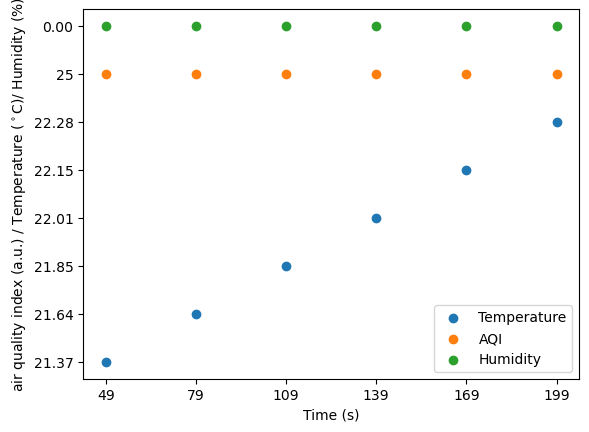

In [15]:
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False    # Remove annoying auto-offset
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()
# Add an axis to the figure
ax = fig.add_subplot(111)
# Tell the axis to plot the data - time on the x-axis, temperature on the y-axis
ax.scatter(df['time'], df['temp'])
# Tell the axis to plot the data - time on the x-axis, air quality reading on the y-axis
ax.scatter(df['time'], df['air quality'])
# Tell the axis to plot the data - time on the x-axis, humidity reading on the y-axis
ax.scatter(df['time'], df['humidity'])

ax.set_xlabel('Time (s)')
# Bonus question - search online to find out what the funny r and $^\circ$ are doing in the line below
ax.set_ylabel(r'air quality index (a.u.) / Temperature ($^\circ$C)/ Humidity (%)')
plt.legend(['Temperature', 'AQI', 'Humidity'])
# Show the figure - not strictly necessary in jupyter notebook, but essential if you're writing a .py file
plt.show()

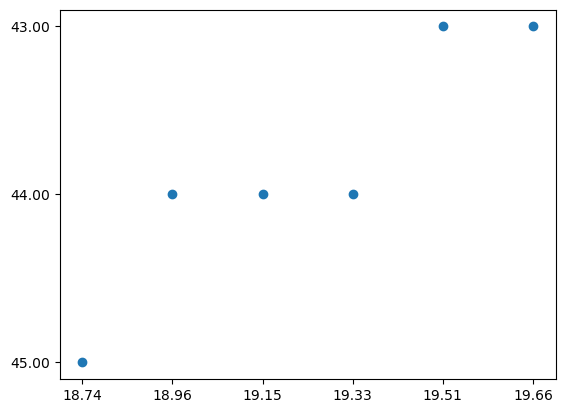

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False    # Remove annoying auto-offset
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()
# Add an axis to the figure
ax = fig.add_subplot(111)
# Tell the axis to plot the data - time on the x-axis, temperature on the y-axis
ax.scatter(df['temp'], df['humidity'])

# Show the figure - not strictly necessary in jupyter notebook, but essential if you're writing a .py file
plt.show()

In [16]:
!pip install ipython-sql

In [8]:
# Load the SQL extension for Jupyter Notebook
%load_ext sql

# Connect to the SQLite database
%sql sqlite:///miniprojecttest.db

# Magic line that fixes a bug
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [9]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('miniprojecttest.db')
cursor = conn.cursor()
cursor.execute(create_table_sql)
conn.commit()

columns = df.columns
column_types = ["TEXT"] * len(columns)  # Assuming all columns can be stored as TEXT, customize if needed
zipped_data = zip(columns, column_types)
table_name = 'sensor_data'

create_table_sql = f"CREATE TABLE IF NOT EXISTS {table_name} (" + ", ".join([f"{col} {col_type}" for col, col_type in zip(columns, column_types)]) + ");"
print(create_table_sql)

NameError: name 'create_table_sql' is not defined

In [ ]:
row = tuple(df.iloc[1])
# Use a parameterized query to avoid SQL syntax errors (and issues with np.int64 repr)
placeholders = ",".join(["?"] * len(row))
insert_sql = f"INSERT INTO {table_name} VALUES ({placeholders})"
# Convert numpy scalar types to native Python types when present
row_vals = tuple((x.item() if hasattr(x, "item") else x) for x in row)
cursor.execute(insert_sql, row_vals)
conn.commit()

In [29]:
for n in range(len(df)):
    row = tuple(df.iloc[n])
    # Use a parameterized query to avoid SQL syntax errors (and issues with np.int64 repr)
    placeholders = ",".join(["?"] * len(row))
    insert_sql = f"INSERT INTO {table_name} VALUES ({placeholders})"
    # Convert numpy scalar types to native Python types when present
    row_vals = tuple((x.item() if hasattr(x, "item") else x) for x in row)
    cursor.execute(insert_sql, row_vals)
conn.commit()

In [30]:
query = f"SELECT * FROM {table_name} LIMIT 5;"
cursor.execute(query)
rows = cursor.fetchall()

# Display the query results
for row in rows:
    print(row)

('1', '75', '22.42', '25', '36.00')
('0', '45', '22.42', '25', '36.00')
('1', '75', '22.42', '25', '36.00')
('2', '105', '22.39', '25', '36.00')
('3', '135', '22.37', '25', '35.00')


In [32]:
conn.close()